# ML from scratch: Stable Diffusion, Day 2

### [Binxu Wang](https://scholar.harvard.edu/binxuw) and [John Vastola](https://twitter.com/johnjvastola)

<p align="center">
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/astro.png?raw=true" alt="drawing" width="150"/>
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/ballerina_chasing_cat.png?raw=true" alt="drawing" width="150"/>
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/lovely_cat.png?raw=true" alt="drawing" width="150"/>
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/turtle3.png?raw=true" alt="drawing" width="150"/>
</p>

On the first day, we went over the various components necessary to make an effective diffusion generative model like [Stable Diffusion](https://ommer-lab.com/research/latent-diffusion-models/).

As a reminder, they are:

- Method of learning to generate new stuff (forward/reverse diffusion)
- Way to link text and images (text-image representation model like [CLIP](https://github.com/openai/CLIP))
- Way to compress images (autoencoder)
- Way to add in good inductive biases (U-net architecture + self/cross-attention)

In today's session, you will implement pieces of each of the above, and by the end have a working Stable-Diffusion-like model.

In particular, you will implement parts of:

- **basic 1D forward/reverse diffusion**
- **a U-Net architecture for working with images**
- **the loss associated with learning the score function**
- **an attention model for conditional generation**
- **an autoencoder**

We need a reasonably small dataset so that training does not take forever, so we will be working with [MNIST](https://en.wikipedia.org/wiki/MNIST_database), a set of 28x28 images of handwritten 0-9 digits. By the end, our model should be able to take in a number prompt (e.g. "4") and output an image of the digit 4.

----------------

In [2]:
!pip install einops
!pip install lpips

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools

from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
from tqdm.notebook import trange, tqdm
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR

import matplotlib.pyplot as plt

from torchvision.utils import make_grid


-------------------------------------------

## 2. Working with images via U-Nets

We just reviewed the very basics of diffusion models, with the takeaway that learning the score function allows us to turn pure noise into something interesting. We will learn to approximate the score function with a neural network. But when we are working with images, we need our neural network to 'play nice' with them, and to reflect inductive biases we associate with images.

A reasonable choice is to choose the neural network architecture to be that of a [U-Net](https://en.wikipedia.org/wiki/U-Net), which combines a CNN-like structure with downscaling/upscaling operations that help the network pay attention to features of images at different spatial scales.  

Since the score function we're trying to learn is a function of time, we also need to come up with a way to make sure our neural network properly responds to changes in time. For this purpose, we can use a **time embedding**.

In this section, **you will fill in some missing U-Net pieces.**

### Helping our neural network work with time

The below code helps our neural network work with time via a **time embedding**. The idea is that, instead of just telling our network one number (the current time), we express the current time in terms of a large number of sinusoidal features. The hope is that, if we tell our network the current time in many different ways, it will more easily respond to changes in time.

This will enable us to successfully learn a time-dependent score function $s(x, t)$.

In [3]:
#@title Get some modules to let time interact

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights (frequencies) during initialization.
    # These weights (frequencies) are fixed during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    # Cosine(2 pi freq x), Sine(2 pi freq x)
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps.
  Allow time repr to input additively from the side of a convolution layer.
  """
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]
    # this broadcast the 2d tensor to 4d, add the same value across space.


### Defining the U-Net architecture

The below class defines a U-Net architecture. **Fill in the missing pieces.** (This shouldn't be hard; mainly, it's to get you to look at the structure.)

In [4]:
#@title Defining a time-dependent score-based model (double click to expand or collapse)

class UNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.time_embed = nn.Sequential(
          GaussianFourierProjection(embed_dim=embed_dim),
          nn.Linear(embed_dim, embed_dim)
          )
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

    ########### YOUR CODE HERE (3 lines)
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    #########################

    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])


    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std

  def forward(self, x, t, y=None):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.time_embed(t))
    # Encoding path
    h1 = self.conv1(x)  + self.dense1(embed)
    ## Incorporate information from t
    ## Group normalization
    h1 = self.act(self.gnorm1(h1))
    h2 = self.conv2(h1) + self.dense2(embed)
    h2 = self.act(self.gnorm2(h2))
    ########## YOUR CODE HERE (2 lines)
    #   apply activation function
    h3 = self.conv3(h2) + self.dense3(embed)
    h3 = self.act(self.gnorm3(h3))
    ############
    h4 = self.conv4(h3) + self.dense4(embed)
    h4 = self.act(self.gnorm4(h4))

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.act(self.tgnorm4(h))
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.act(self.tgnorm3(h))
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.act(self.tgnorm2(h))
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

Below is code for an alternate U-Net architecture. Apparently, diffusion models can be successful with somewhat different architectural details. (Note that the differences from the above class are kind of subtle, though.)

* Upper one, **concatenate the tensor from the down block** for skip connection.
* Lower one, directly **add the tensor from the down blocks** for skip connection.
  * A special case of the upper

In [5]:
#@title Alternative time-dependent score-based model (double click to expand or collapse)

class UNet_res(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.time_embed = nn.Sequential(
          GaussianFourierProjection(embed_dim=embed_dim),
          nn.Linear(embed_dim, embed_dim)
          )
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)     #  + channels[2]
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)     #  + channels[1]
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1) #  + channels[0]

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std

  def forward(self, x, t, y=None):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.time_embed(t))
    # Encoding path
    h1 = self.conv1(x)  + self.dense1(embed)
    ## Incorporate information from t
    ## Group normalization
    h1 = self.act(self.gnorm1(h1))
    h2 = self.conv2(h1) + self.dense2(embed)
    h2 = self.act(self.gnorm2(h2))
    h3 = self.conv3(h2) + self.dense3(embed)
    h3 = self.act(self.gnorm3(h3))
    h4 = self.conv4(h3) + self.dense4(embed)
    h4 = self.act(self.gnorm4(h4))

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.act(self.tgnorm4(h))
    h = self.tconv3(h + h3)
    h += self.dense6(embed)
    h = self.act(self.tgnorm3(h))
    h = self.tconv2(h + h2)
    h += self.dense7(embed)
    h = self.act(self.tgnorm2(h))
    h = self.tconv1(h + h1)

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

**Tips**: When you feel uncertain about the shape of the tensors throughout the layers, define the layers outside and see the shapes. This format could be helpful.

In [ ]:
net = nn.Sequential(
    nn.Conv2d(...),
    nn.ConvTranspose2d(...),
)
x = torch.randn(...)
for l in net:
    x = layer(x)
    print(x.shape)

----------------

## 3. Train the U-Net to learn a score function

Let's combine the U-Net we just defined with a way to learn the score function. We need to define a loss function, and then train a neural network in the usual way.

In the next cell, we will define the specific forward diffusion process
$$
dx = \sigma^t dw
$$
the "diffusion constant" $\sigma^t$ adds noise to $x$ samples with exponentially increasing noise scale.

Given this forward process, and given a starting $x(0)$ we have an analytically solution for the sample at any time $x(t)$
$$
p(x(t)|x(0))=\mathcal N(x(0),\sigma(t)^2)
$$
We call $\sigma(t)$ the marginal std, i.e. the standard deviation of the conditional distribution. In this specific case,
$$
\sigma^2(t)=\int_0^t (\sigma^\tau ) ^2d\tau = \int_0^t \sigma^{2\tau} d\tau = \frac{\sigma^{2t}-1}{2\log \sigma }
$$

In [6]:
#@title Diffusion constant and noise strength
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The standard deviation.
  """
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)

sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

### Defining the loss function

The loss function is mostly defined below. **You need to add one part**: sample random noise with strength `std[:, None, None, None]`, and make sure it has the same shape as $\mathbf{x}$. Then use this to perturb $\mathbf{x}$.

*Hint: `torch.randn_like()` may be useful.*

In [7]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  # Sample time uniformly in 0, 1
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  # Find the noise std at the time `t`
  std = marginal_prob_std(random_t)
  ####### YOUR CODE HERE  (2 lines)
  z = torch.randn_like(x)             # get normally distributed noise
  perturbed_x = x + z * std[:, None, None, None]
  ##############
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

### Defining the sampler

In [8]:
#@title Sampler code
num_steps = 500#@param {'type':'integer'}
def Euler_Maruyama_sampler(score_model,
              marginal_prob_std,
              diffusion_coeff,
              batch_size=64,
              x_shape=(1, 28, 28),
              num_steps=num_steps,
              device='cuda',
              eps=1e-3, y=None):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

  Returns:
    Samples.
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, *x_shape, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
  # Do not include any noise in the last sampling step.
  return mean_x

### Training on MNIST

We will train on MNIST, and learn to generate pictures that look like 0-9 digits. No code to fill in here; just run it and see if it works!

In the following code, the loss could descent to ~ 40-50.

In [9]:
#@title Training (double click to expand or collapse)

score_model = torch.nn.DataParallel(UNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs =   50#@param {'type':'integer'}
## size of a mini-batch
batch_size =  2048 #@param {'type':'integer'}
## learning rate
lr=5e-4 #@param {'type':'number'}

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in tqdm(data_loader):
    x = x.to(device)
    loss = loss_fn(score_model, x, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'ckpt.pth')

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 895655.06it/s] 


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 130228.37it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1057402.67it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2889946.72it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

<ipython-input-6-e9db09bfa051>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In the following code, the loss could descent to ~ 25, with relatively good quality.

In [10]:
#@title Training the alternate U-Net model (double click to expand or collapse)

score_model = torch.nn.DataParallel(UNet_res(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs =   75#@param {'type':'integer'}
## size of a mini-batch
batch_size =  1024 #@param {'type':'integer'}
## learning rate
lr=10e-4 #@param {'type':'number'}

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in data_loader:
    x = x.to(device)
    loss = loss_fn(score_model, x, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  scheduler.step()
  lr_current = scheduler.get_last_lr()[0]
  print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'ckpt_res.pth')

  0%|          | 0/75 [00:00<?, ?it/s]

<ipython-input-6-e9db09bfa051>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


0 Average Loss: 1107.010191 lr 9.8e-04
1 Average Loss: 277.106053 lr 9.6e-04
2 Average Loss: 184.252436 lr 9.4e-04
3 Average Loss: 140.785195 lr 9.2e-04
4 Average Loss: 115.963227 lr 9.0e-04
5 Average Loss: 100.064895 lr 8.9e-04
6 Average Loss: 89.082955 lr 8.7e-04
7 Average Loss: 80.679490 lr 8.5e-04
8 Average Loss: 74.199827 lr 8.3e-04
9 Average Loss: 69.669551 lr 8.2e-04
10 Average Loss: 65.168034 lr 8.0e-04
11 Average Loss: 61.733229 lr 7.8e-04
12 Average Loss: 59.474007 lr 7.7e-04
13 Average Loss: 56.874162 lr 7.5e-04
14 Average Loss: 54.352366 lr 7.4e-04
15 Average Loss: 52.185929 lr 7.2e-04
16 Average Loss: 50.906654 lr 7.1e-04
17 Average Loss: 49.354610 lr 7.0e-04
18 Average Loss: 47.892864 lr 6.8e-04
19 Average Loss: 46.393211 lr 6.7e-04
20 Average Loss: 45.323162 lr 6.5e-04
21 Average Loss: 44.260986 lr 6.4e-04
22 Average Loss: 43.140311 lr 6.3e-04
23 Average Loss: 42.289950 lr 6.2e-04
24 Average Loss: 40.917790 lr 6.0e-04
25 Average Loss: 40.440325 lr 5.9e-04
26 Average Loss

Visualize the results of training below.

In [25]:
def save_samples_uncond(score_model, num_steps):
  score_model.eval()
  ## Generate samples using the specified sampler.
  sample_batch_size = 64 #@param {'type':'integer'}
  sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
  # score_model.eval()
  ## Generate samples using the specified sampler.
  samples = sampler(score_model,
          marginal_prob_std_fn,
          diffusion_coeff_fn,
          sample_batch_size,
          num_steps=num_steps,
          device=device,
          )

      ## Sample visualization.
  samples = samples.clamp(0.0, 1.0)
  sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))
  sample_np = sample_grid.permute(1, 2, 0).cpu().numpy()
  plt.imsave(f"uncondition_diffusion.png", sample_np,)
  plt.figure(figsize=(6,6))
  plt.axis('off')
  plt.imshow(sample_np, vmin=0., vmax=1.)
  plt.show()


<ipython-input-6-e9db09bfa051>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/250 [00:00<?, ?it/s]

<ipython-input-6-e9db09bfa051>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


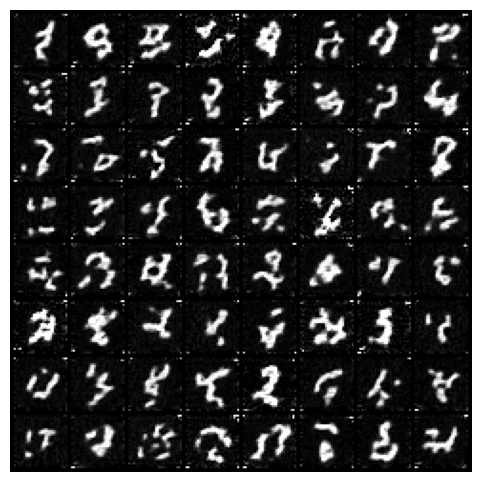

  0%|          | 0/500 [00:00<?, ?it/s]

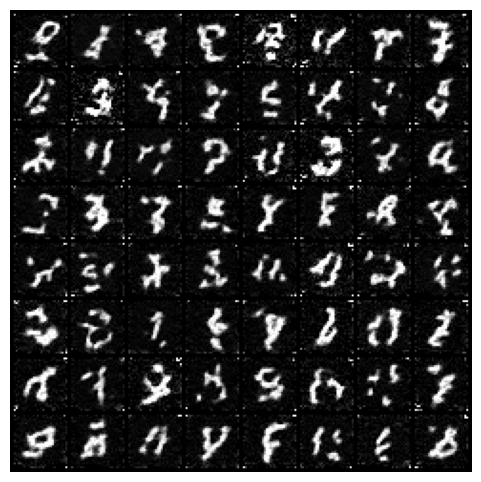

In [26]:
score_model = torch.nn.DataParallel(UNet(marginal_prob_std=marginal_prob_std_fn))
score_model.load_state_dict(torch.load("ckpt.pth"))
save_samples_uncond(score_model, num_steps = 250)
save_samples_uncond(score_model, num_steps = 500)

<ipython-input-6-e9db09bfa051>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/250 [00:00<?, ?it/s]

<ipython-input-6-e9db09bfa051>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


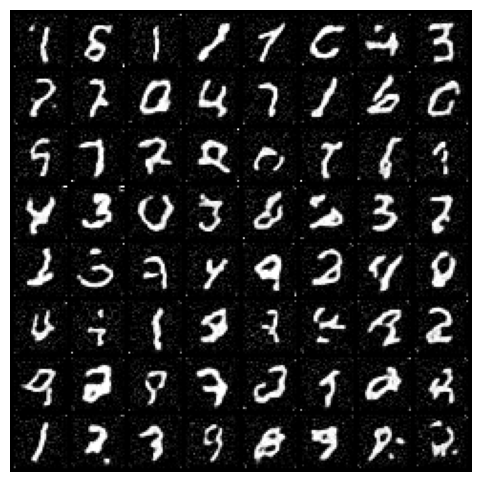

  0%|          | 0/500 [00:00<?, ?it/s]

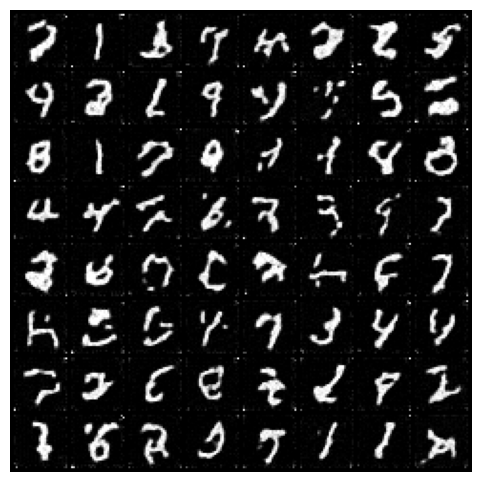

In [27]:
score_model = torch.nn.DataParallel(UNet_res(marginal_prob_std=marginal_prob_std_fn))
score_model.load_state_dict(torch.load("ckpt_res.pth"))
save_samples_uncond(score_model, num_steps = 250)
save_samples_uncond(score_model, num_steps = 500)